In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import scvelo as scv
import latentvelo as ltv

Global seed set to 0


In [2]:
adata = sc.read('data/preprocessed_clusters.h5ad')

In [3]:
adata.X = adata.layers['spliced'].copy()

In [4]:
adata  = ltv.utils.anvi_clean_recipe(adata, umap=True, celltype_key='clusters', batch_key = 'timepoint',
                           n_top_genes=2000, root_cells='NMP')

Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing UMAP


In [6]:
np.save('selected_genes.npy', adata.var.index.values)

saving figure to file figures/Unintegrated_timepoints_umap.png


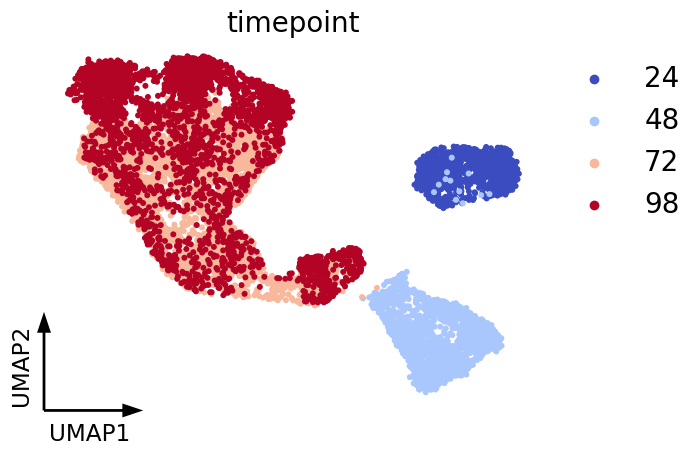

In [6]:
scv.pl.umap(adata, color=['timepoint'], frameon='artist', size=75, palette='coolwarm',
           save='figures/Unintegrated_timepoints_umap.png', fontsize=20, legend_fontsize=20)

saving figure to file figures/Unintegrated_clusters_umap.png


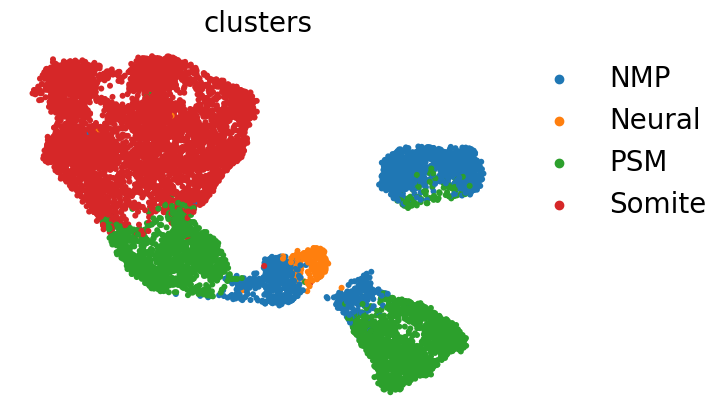

In [7]:
scv.pl.umap(adata, color=['clusters'], frameon='none', size=75,
           save='figures/Unintegrated_clusters_umap.png', fontsize=20, legend_fontsize=20)

In [8]:
model = ltv.models.VAE(observed=2000, latent_dim=20 , zr_dim=2, h_dim=2, 
                       encoder_hidden=25, celltypes=len(adata.obs.clusters.unique()),
                    batch_correction=True, batches = len(adata.obs.timepoint.unique()), root_weight=10000,
                    time_reg_decay=10)

epochs, val_ae, val_traj, _, _ = ltv.train(model, adata, batch_size = 200, learning_rate=2e-2,
                                      epochs=0, name='segmentoid_May11', grad_clip=1000, timing=True)

Warning, folder already exists. This may overwrite a previous fit.
665 velocity genes used
Loading best model at 0 epochs.


In [9]:
import torch as th
model.load_state_dict(th.load('segmentoid_May11/model_state_epoch25.params',map_location=th.device('cuda')))

<All keys matched successfully>

In [10]:
latent_adata = ltv.output_results(model, adata)

In [11]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/9370 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


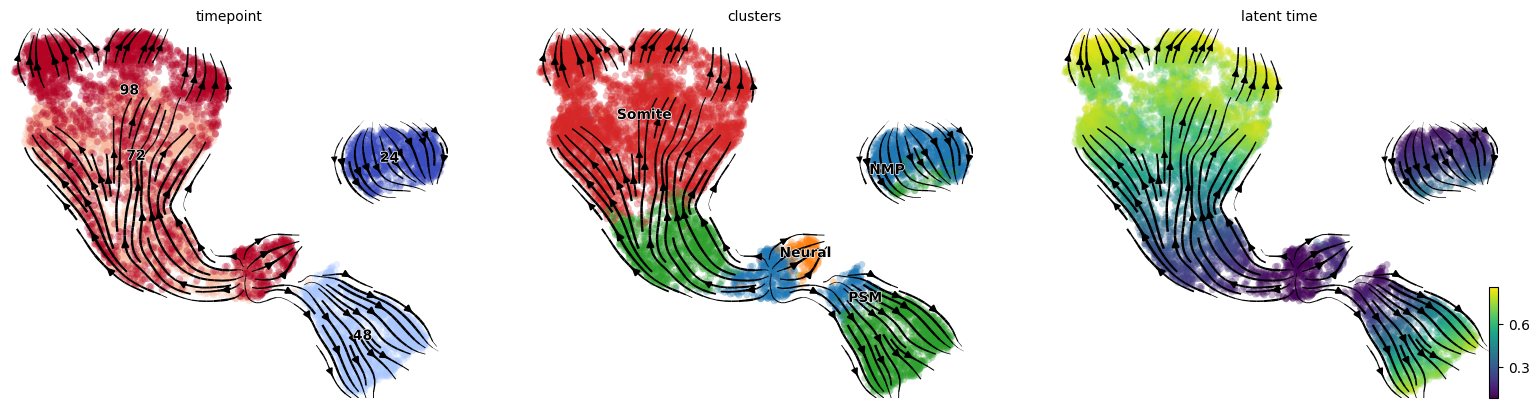

In [12]:
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['timepoint', 'clusters', 'latent_time'])

In [13]:
latent_adata.obs['timepoint'] = latent_adata.obs['timepoint'].astype(int)

In [15]:
cluster_edges = [
    ('NMP', 'Neural'), 
    ('NMP', 'PSM'),
    ('PSM', 'Somite')]

scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
scores_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', cluster_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:03) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


In [16]:
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.umap(latent_adata, min_dist=1)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/9370 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


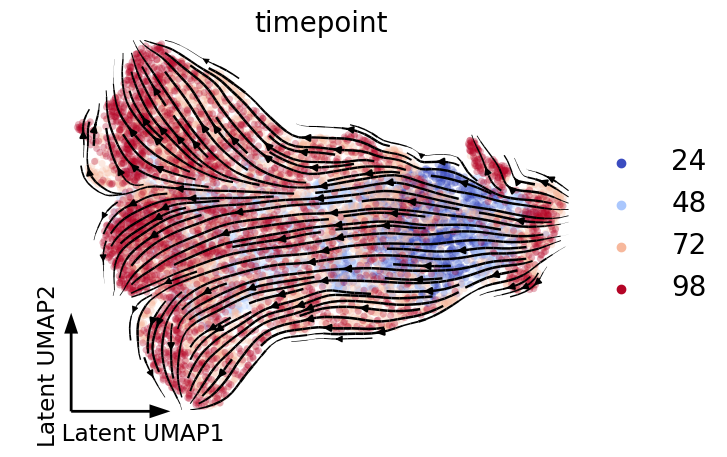

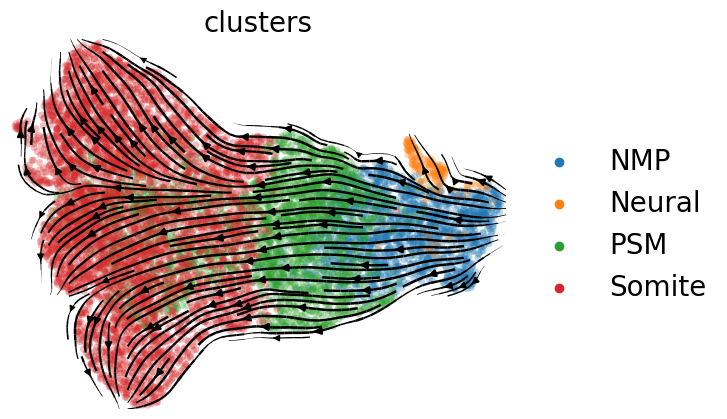

In [17]:
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', 
                                 color=['timepoint'], frameon='artist',
                                cutoff_perc=0, legend_loc='right', fontsize=20, legend_fontsize=20,
                                #save='figures/integrated_velocity_umap_timepoint.png',
                                xlabel='       Latent UMAP1', ylabel='Latent UMAP2')

scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', 
                                 color=['clusters'], 
                                cutoff_perc=0, legend_loc='right', fontsize=20, legend_fontsize=20)#,
                                #save='figures/integrated_velocity_umap_clusters.png')

In [18]:
metrics_unint = ltv.ev.integration_metrics(latent_adata, label_key='clusters', 
                                         batch_key = 'timepoint', 
                                     emb_key='X_pca')

/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: Us

In [19]:
latent_adata.obsm['X_latent'] = latent_adata.X.copy()

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
metrics = ltv.ev.integration_metrics(latent_adata, label_key='clusters', 
                                         batch_key = 'timepoint', 
                                     emb_key='X_latent')

/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: Us

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/ann

Adding diffusion to step 4
Adding diffusion to step 5


/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/ann

Adding diffusion to step 4


/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (4964×4964).

These matrices should now be stored in the .obsp attribute.
This slicin

In [21]:
metrics, metrics_unint

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


({'cLISI': [0.9574118034118012],
  'kBET': [0.2044225214404296],
  'iLISI': [0.3191432717277151]},
 {'cLISI': [0.9999999999999999],
  'kBET': [0.09672434607645874],
  'iLISI': [0.04086990647722984]})

In [22]:
nn_velo_metics = ltv.ev.nn_velo(latent_adata, layer=True, batch_key='timepoint',
        vkey='spliced_velocity')

metrics['NN velocity'] =  [nn_velo_metics[0]]

/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['spliced_velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


In [23]:
metrics_unint['NN velocity'] = [np.nan]

In [24]:
metrics['CBDir'] = [np.concatenate(list(scores_pca.values())).mean()]
metrics_unint['CBDir'] = [np.nan]

In [25]:
adata_combat_unitvelo = sc.read('segmentoid_unitvelo_adata.h5ad')

/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
cluster_edges = [
    ('NMP', 'Neural'), 
    ('NMP', 'PSM'),
    ('PSM', 'Somite')]

scv.tl.velocity_embedding(adata_combat_unitvelo, vkey='velocity', basis='pca')
unitvelo_pca = ltv.ev.cross_boundary_correctness(adata_combat_unitvelo,
                                  'clusters', 'velocity_pca', cluster_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

/home/spencer/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/spencer/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/evaluation/metrics.py:176: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x_emb == "X_umap":


In [29]:
metrics_unitvelo = {}
metrics_unitvelo['CBDir'] = [np.concatenate(list(unitvelo_pca.values())).mean()]

nn_velo_metics = ltv.ev.nn_velo(adata_combat_unitvelo, layer=False, batch_key='timepoint',
        vkey='velocity_pca')

metrics_unitvelo['NN velocity'] =  [nn_velo_metics[0]]

/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


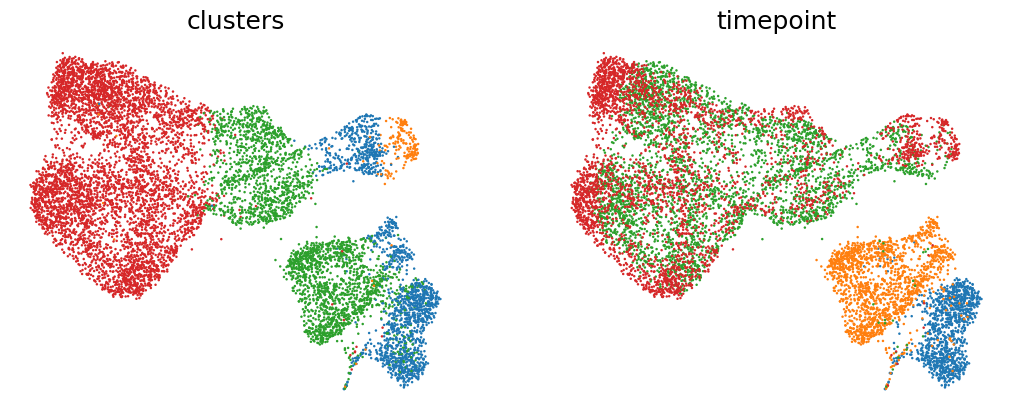

In [30]:
scv.pl.umap(adata_combat_unitvelo, color=['clusters','timepoint'])

In [31]:
metrics_unitvelo_ = ltv.ev.integration_metrics(adata_combat_unitvelo, label_key='clusters', 
                                         batch_key = 'timepoint', 
                                     emb_key='X_pca')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Obser

In [32]:
metrics_unitvelo['cLISI'] = metrics_unitvelo_['cLISI']

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
metrics_unitvelo

{'CBDir': [0.6369574253289851],
 'NN velocity': [0.8448525],
 'cLISI': [0.9966868462782735]}

In [34]:
metrics_unitvelo

{'CBDir': [0.6369574253289851],
 'NN velocity': [0.8448525],
 'cLISI': [0.9966868462782735]}

In [35]:
metrics, metrics_unint, metrics_unitvelo

({'cLISI': [0.9574118034118012],
  'kBET': [0.2044225214404296],
  'iLISI': [0.3191432717277151],
  'NN velocity': [0.98220456],
  'CBDir': [0.8552771292297646]},
 {'cLISI': [0.9999999999999999],
  'kBET': [0.09672434607645874],
  'iLISI': [0.04086990647722984],
  'NN velocity': [nan],
  'CBDir': [nan]},
 {'CBDir': [0.6369574253289851],
  'NN velocity': [0.8448525],
  'cLISI': [0.9966868462782735]})

In [36]:
adata_unint_unitvelo = sc.read('segmentoid_unitvelo_unintegrated_adata.h5ad')

/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [37]:
cluster_edges = [
    ('NMP', 'Neural'), 
    ('NMP', 'PSM'),
    ('PSM', 'Somite')]

scv.tl.velocity_embedding(adata_unint_unitvelo, vkey='velocity', basis='pca')
unitvelo_unint_pca = ltv.ev.cross_boundary_correctness(adata_unint_unitvelo,
                                  'clusters', 'velocity_pca', cluster_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/spencer/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/spencer/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/usr/local/lib/python3.8/dist-packages/latentvelo-0.1-py3.8.egg/latentvelo/evaluation/metrics.py:176: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x_emb == "X_umap":


In [38]:
metrics_unint['CBDir'] = [np.concatenate(list(unitvelo_unint_pca.values())).mean()]

nn_velo_metics = ltv.ev.nn_velo(adata_unint_unitvelo, layer=False, batch_key='timepoint',
        vkey='velocity_pca')

metrics_unint['NN velocity'] =  [nn_velo_metics[0]]

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be 

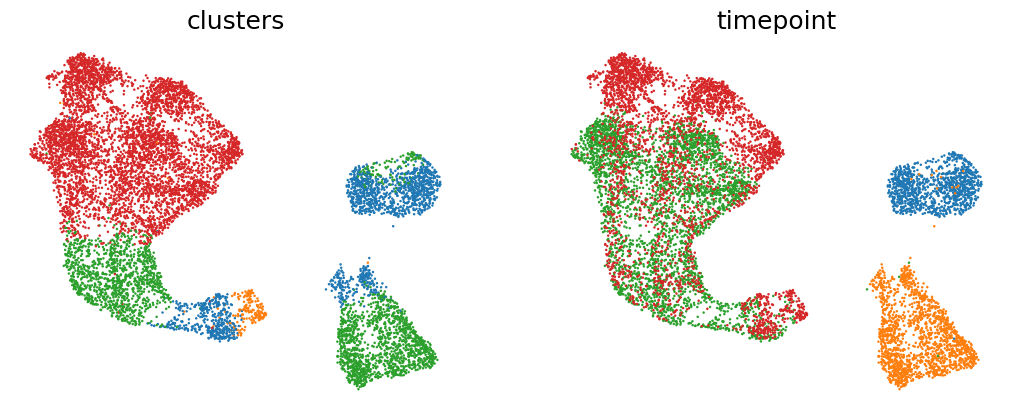

In [39]:
scv.pl.umap(adata_unint_unitvelo, color=['clusters','timepoint'])

In [40]:
metrics_unint_ = ltv.ev.integration_metrics(adata_unint_unitvelo, label_key='clusters', 
                                         batch_key = 'timepoint', 
                                     emb_key='X_pca')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (9370×9370).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/spencer/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Obser

In [41]:
metrics_unint

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'cLISI': [0.9999999999999999],
 'kBET': [0.09672434607645874],
 'iLISI': [0.04086990647722984],
 'NN velocity': [0.9058708],
 'CBDir': [0.6545260743025862]}

In [42]:
del metrics['iLISI']
del metrics_unint['iLISI']

In [43]:
del metrics['kBET']
del metrics_unint['kBET']

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
def integration_metrics(models, model_names, x = 'score', hue='Model', edgecolor='#474747ff', height=5, aspect=1., palette=None):
    
    batch_correction = pd.DataFrame(pd.concat([pd.DataFrame(m).T for m in models], axis=0))
    model_names_ = []
    for mn in model_names:
        model_names_ = model_names_ + pd.DataFrame(models[0]).shape[1]*[mn]
    batch_correction['Model'] = model_names_ 
    batch_correction['score'] = batch_correction[0]
    batch_correction = batch_correction.drop(0, 1)
    batch_correction['Metric'] = batch_correction.index.values
    
    ax = sns.catplot(
        data=batch_correction, 
        x='Metric', y=x, kind='bar', hue = hue,
        alpha=1, orient='v', height=height, aspect=aspect, palette = palette, edgecolor=edgecolor
    )
    
    ax.set(ylim=(0, 1))
    
    return ax

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-50-d44c81219562>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  batch_correction = batch_correction.drop(0, 1)


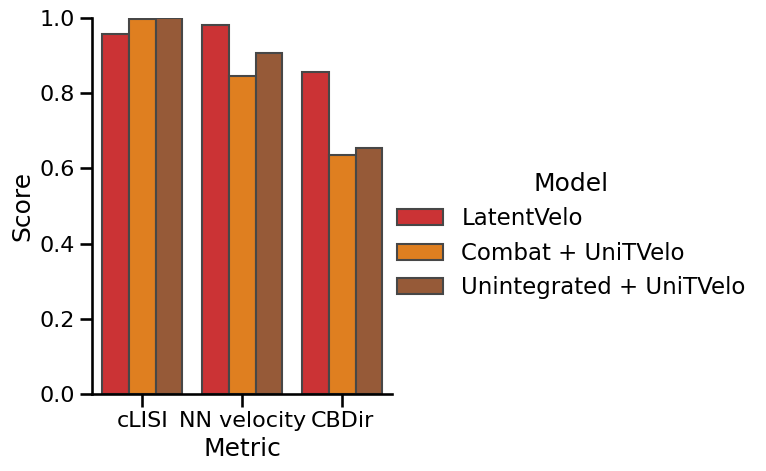

In [54]:

ax=integration_metrics([metrics, metrics_unitvelo, metrics_unint],
                 ['LatentVelo','Combat + UniTVelo', 'Unintegrated + UniTVelo'],
                           edgecolor='#474747ff',height=5, aspect=1,
                        palette=np.array(sns.color_palette("Set1").as_hex())[[0, 4,6]])
#ax.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Score', fontsize=18)
plt.xlabel('Metric', fontsize=18)
plt.savefig('figures/integration_metrics_segmentoid.pdf')
plt.show()